# Import and install

In [2]:
import pandas as pd
import numpy as np
import torch

import torch.nn as nn

import requests

import os

# Functions

In [3]:
def sigla_to_province(sigla):
    sigla_map = {
        "AG": "Agrigento",
        "AL": "Alessandria",
        "AN": "Ancona",
        "AO": "Aosta",
        "AR": "Arezzo",
        "AP": "Ascoli Piceno",
        "AT": "Asti",
        "AV": "Avellino",
        "BA": "Bari",
        "BT": "Barletta-Andria-Trani",
        "BL": "Belluno",
        "BN": "Benevento",
        "BG": "Bergamo",
        "BI": "Biella",
        "BO": "Bologna",
        "BZ": "Bolzano",
        "BS": "Brescia",
        "BR": "Brindisi",
        "CA": "Cagliari",
        "CL": "Caltanissetta",
        "CB": "Campobasso",
        "CI": "Carbonia-Iglesias",
        "CE": "Caserta",
        "CT": "Catania",
        "CZ": "Catanzaro",
        "CH": "Chieti",
        "CO": "Como",
        "CS": "Cosenza",
        "CR": "Cremona",
        "KR": "Crotone",
        "CN": "Cuneo",
        "EN": "Enna",
        "FM": "Fermo",
        "FE": "Ferrara",
        "FI": "Firenze",
        "FG": "Foggia",
        "FC": "Forlì-Cesena",
        "FR": "Frosinone",
        "GE": "Genova",
        "GO": "Gorizia",
        "GR": "Grosseto",
        "IM": "Imperia",
        "IS": "Isernia",
        "AQ": "L'Aquila",
        "SP": "La Spezia",
        "LT": "Latina",
        "LE": "Lecce",
        "LC": "Lecco",
        "LI": "Livorno",
        "LO": "Lodi",
        "LU": "Lucca",
        "MC": "Macerata",
        "MN": "Mantova",
        "MS": "Massa-Carrara",
        "MT": "Matera",
        "VS": "Medio Campidano",
        "ME": "Messina",
        "MI": "Milano",
        "MO": "Modena",
        "MB": "Monza e Brianza",
        "NA": "Napoli",
        "NO": "Novara",
        "NU": "Nuoro",
        "OR": "Oristano",
        "PD": "Padova",
        "PA": "Palermo",
        "PR": "Parma",
        "PV": "Pavia",
        "PG": "Perugia",
        "PU": "Pesaro e Urbino",
        "PE": "Pescara",
        "PC": "Piacenza",
        "PI": "Pisa",
        "PT": "Pistoia",
        "PN": "Pordenone",
        "PZ": "Potenza",
        "PO": "Prato",
        "RG": "Ragusa",
        "RA": "Ravenna",
        "RC": "Reggio Calabria",
        "RE": "Reggio Emilia",
        "RI": "Rieti",
        "RN": "Rimini",
        "RM": "Roma",
        "RO": "Rovigo",
        "SA": "Salerno",
        "SS": "Sassari",
        "SV": "Savona",
        "SI": "Siena",
        "SR": "Siracusa",
        "SO": "Sondrio",
        "TA": "Taranto",
        "TE": "Teramo",
        "TR": "Terni",
        "TO": "Torino",
        "TP": "Trapani",
        "TN": "Trento",
        "TV": "Treviso",
        "TS": "Trieste",
        "UD": "Udine",
        "VA": "Varese",
        "VE": "Venezia",
        "VB": "Verbano-Cusio-Ossola",
        "VC": "Vercelli",
        "VR": "Verona",
        "VV": "Vibo Valentia",
        "VI": "Vicenza",
        "VT": "Viterbo"
    }
    return sigla_map.get(sigla.upper(), None)

def replace_comma(text):
    if isinstance(text, str):
        return text.replace(",", ".")
    return text

buffer = {}

def get_province_coordinates(province_name):

    if province_name in buffer:
        return buffer[province_name]
    
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": f"{province_name}, Italy",
        "format": "json",
        "addressdetails": 1,
        "limit": 1
    }
    headers = {
        "User-Agent": "YourAppNameHere"  # Nominatim requires a valid user agent
    }

    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = float(data[0]["lat"])
            lon = float(data[0]["lon"])
            buffer[province_name] = (lat, lon)
            return lat, lon
        else:
            print("No results found.")
            return None
    else:
        print(f"Error: {response.status_code}")
        return None

def get_latitude(province):
    lat, lon = get_province_coordinates(province)
    return lat

def get_longitude(province):
    lat, lon = get_province_coordinates(province)
    return lon

In [11]:
df = pd.read_csv('data/original.csv')
df = df.dropna()

df['CLAIM_PROVINCE'] = df['CLAIM_PROVINCE'].apply(sigla_to_province)
df['CLAIM_LATITUDE'] = df['CLAIM_PROVINCE'].apply(get_latitude)
df['CLAIM_LONGITUDE'] = df['CLAIM_PROVINCE'].apply(get_longitude)
df['CLAIM_DATE'] = df['CLAIM_DATE'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

df = df[df['POLICYHOLDER_AGE'] > 14]
df = df[df['POLICYHOLDER_AGE'] < 100]
df = df[~df['WARRANTY'].isin(['CIVIL LIABILITY FOR NON-COMMERCIAL VEHICLES', 'KASCO AT FIRST ABSOLUTE RISK', 'DRIVER ACCIDENTS - HOSPITAL DAILY ALLOWANCE'])]

df['CLAIM_AMOUNT_PAID'] = df['CLAIM_AMOUNT_PAID'].apply(replace_comma).astype(float)
df['PREMIUM_AMOUNT_PAID'] = df['PREMIUM_AMOUNT_PAID'].apply(replace_comma).astype(float)

df['RATIO'] = df['PREMIUM_AMOUNT_PAID']/ df['CLAIM_AMOUNT_PAID'] 

df.head()

,CLAIM_ID,POLICYHOLDER_AGE,POLICYHOLDER_GENDER,WARRANTY,CLAIM_DATE,CLAIM_REGION,CLAIM_PROVINCE,VEHICLE_BRAND,VEHICLE_MODEL,CLAIM_AMOUNT_PAID,PREMIUM_AMOUNT_PAID,CLAIM_LATITUDE,CLAIM_LONGITUDE,RATIO
0,1,49,M,CIVIL LIABILITY INSURANCE,2022-06-04,TOSCANA,Grosseto,BMW,Serie 3 (E46),8000.00,393.20,42.775110,11.287804,0.049150
2,3,75,F,CIVIL LIABILITY INSURANCE,2023-12-20,CALABRIA,Reggio Calabria,FIAT,PANDA 2A SERIE,1316.44,393.20,38.103539,15.639756,0.298684
3,4,63,M,TRAVEL ASSISTANCE,2024-01-16,TOSCANA,Massa-Carrara,IVECO,DAILY (1992-1996),309.15,32.21,44.213149,10.052561,0.104189
4,5,65,F,CIVIL LIABILITY INSURANCE,2022-08-10,LAZIO,Viterbo,SMART,forfour 2as. (W453),1057.70,393.20,42.492952,11.948814,0.371750
5,6,56,M,CIVIL LIABILITY INSURANCE,2022-11-17,MARCHE,Pesaro e Urbino,YAMAHA,MAJESTY,476.00,393.20,43.694113,12.701444,0.826050


In [12]:
df.to_csv('data/processed.csv', index=False)

In [4]:
df = pd.read_csv('data/processed.csv')

In [7]:
df.head()

,CLAIM_ID,POLICYHOLDER_AGE,POLICYHOLDER_GENDER,WARRANTY,CLAIM_DATE,CLAIM_REGION,CLAIM_PROVINCE,VEHICLE_BRAND,VEHICLE_MODEL,CLAIM_AMOUNT_PAID,PREMIUM_AMOUNT_PAID,CLAIM_LATITUDE,CLAIM_LONGITUDE,RATIO
0,1,49,M,CIVIL LIABILITY INSURANCE,2022-06-04,TOSCANA,Grosseto,BMW,Serie 3 (E46),8000.00,393.20,42.775110,11.287804,0.049150
1,3,75,F,CIVIL LIABILITY INSURANCE,2023-12-20,CALABRIA,Reggio Calabria,FIAT,PANDA 2A SERIE,1316.44,393.20,38.103539,15.639756,0.298684
2,4,63,M,TRAVEL ASSISTANCE,2024-01-16,TOSCANA,Massa-Carrara,IVECO,DAILY (1992-1996),309.15,32.21,44.213149,10.052561,0.104189
3,5,65,F,CIVIL LIABILITY INSURANCE,2022-08-10,LAZIO,Viterbo,SMART,forfour 2as. (W453),1057.70,393.20,42.492952,11.948814,0.371750
4,6,56,M,CIVIL LIABILITY INSURANCE,2022-11-17,MARCHE,Pesaro e Urbino,YAMAHA,MAJESTY,476.00,393.20,43.694113,12.701444,0.826050


<Axes: title={'center': 'Number of Claims by Region'}>

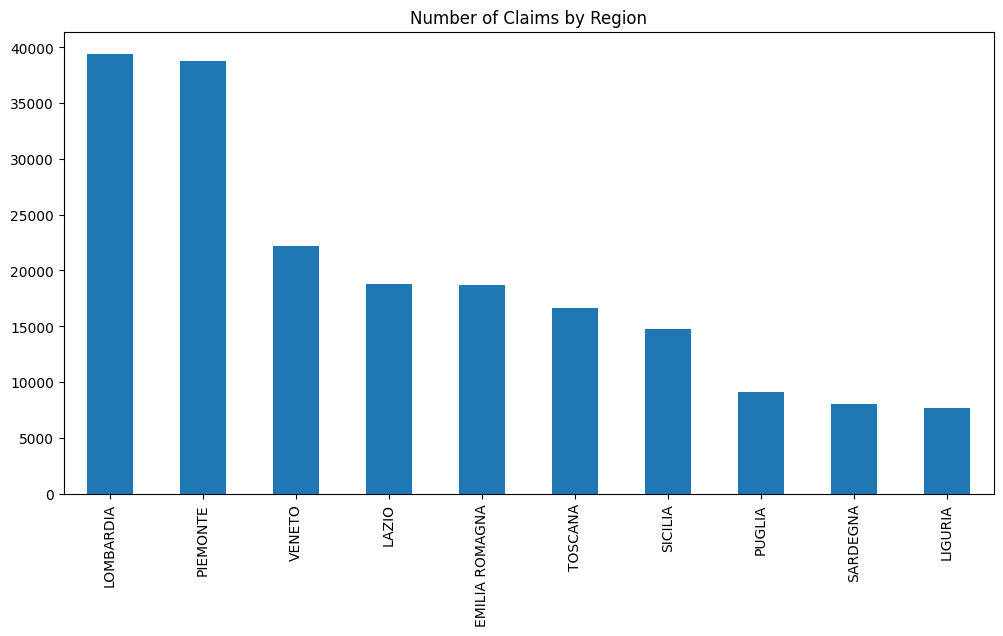

In [7]:
df.groupby('CLAIM_REGION')['CLAIM_ID'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12, 6), title="Number of Claims by Region", xlabel="")

# TODO
1. Gruop by region and plot claim/premium


<Axes: title={'center': 'Mean Ratio by Region'}, xlabel='Region', ylabel='Mean Ratio'>

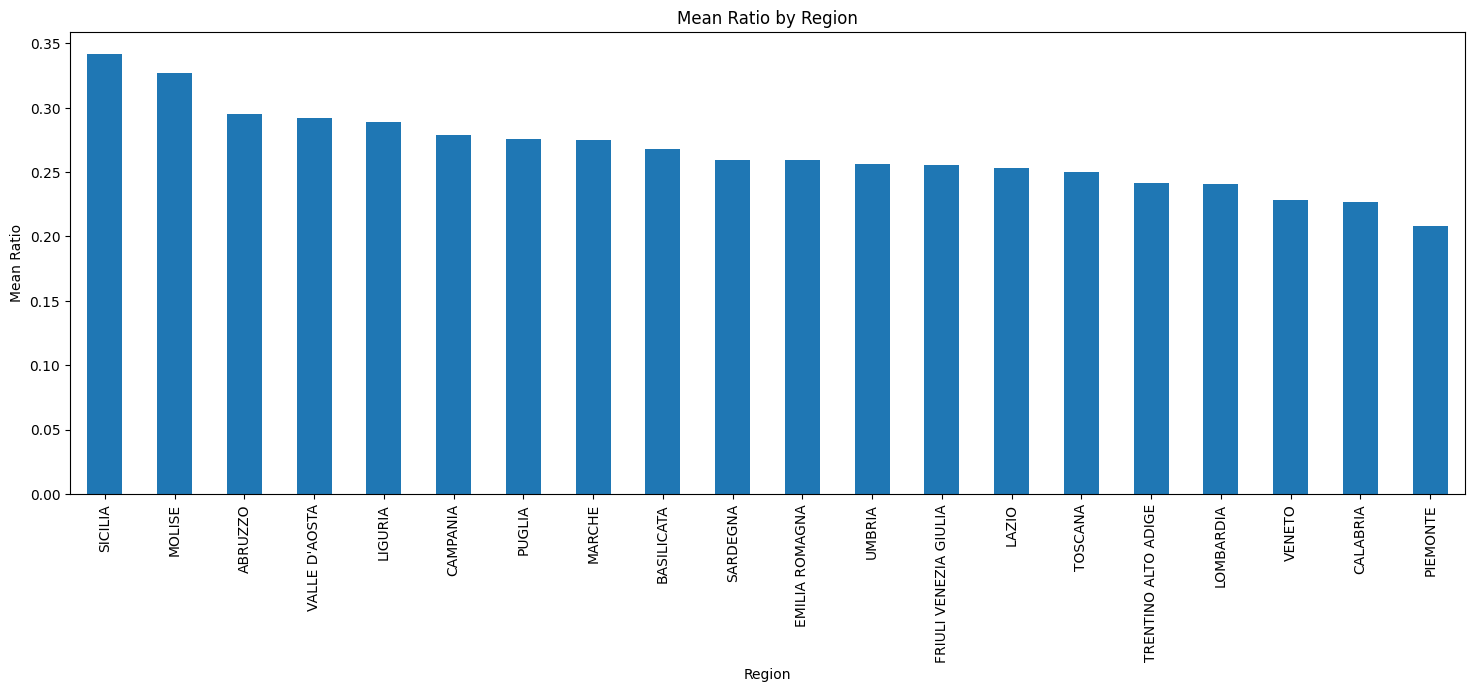

In [8]:
# Group by region and calculate the mean ratio
mean_ratio_by_region = df.groupby('CLAIM_REGION')['RATIO'].mean().sort_values(ascending=False)

# Plot the mean ratio by region
mean_ratio_by_region.plot(kind='bar', figsize=(18, 6), title="Mean Ratio by Region", xlabel="Region", ylabel="Mean Ratio")

In [80]:
# normalize with respect to the number of claims

groped_by_warranty = df.groupby(by='WARRANTY')['CLAIM_ID'].count().sort_values(ascending=False)



In [81]:
df['NORMED_RATIO'] = None
max_value = groped_by_warranty.max

for i, row in df.iterrows():
    row.at(i, 'NORMED_RATIO') = row['RATIO'] / (max_value + 1 - groped_by_warranty[row['WARRANTY']])

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (2817540182.py, line 5)

In [82]:
groped_by_warranty

WARRANTY
CIVIL LIABILITY INSURANCE                  135704
GLASSES                                     34881
TRAVEL ASSISTANCE                           26584
NATURAL DISASTERS                           12860
SOCIOPOLITICAL EVENTS                        5985
SPECIAL TRAVEL                               3421
GUARANTEE FAILURES                           2540
THEFT                                        2428
SAFE REIMBURSEMENT OPTION                    1054
GREEN LINE                                    946
ADDITIONAL COVERAGES                          497
POLE POSITION ASSISTANCE                      405
LEGAL PROTECTION                              211
OVER 65                                       169
WILD ANIMAL COLLISION                         141
VEHICLE FIRE                                   98
DRIVER ACCIDENTS - PERMANENT DISABILITY        85
ACCIDENTS                                      73
COLLISION WITH FOREIGN VEHICLES                65
DRIVER ACCIDENTS - MEDICAL EXPENSES      

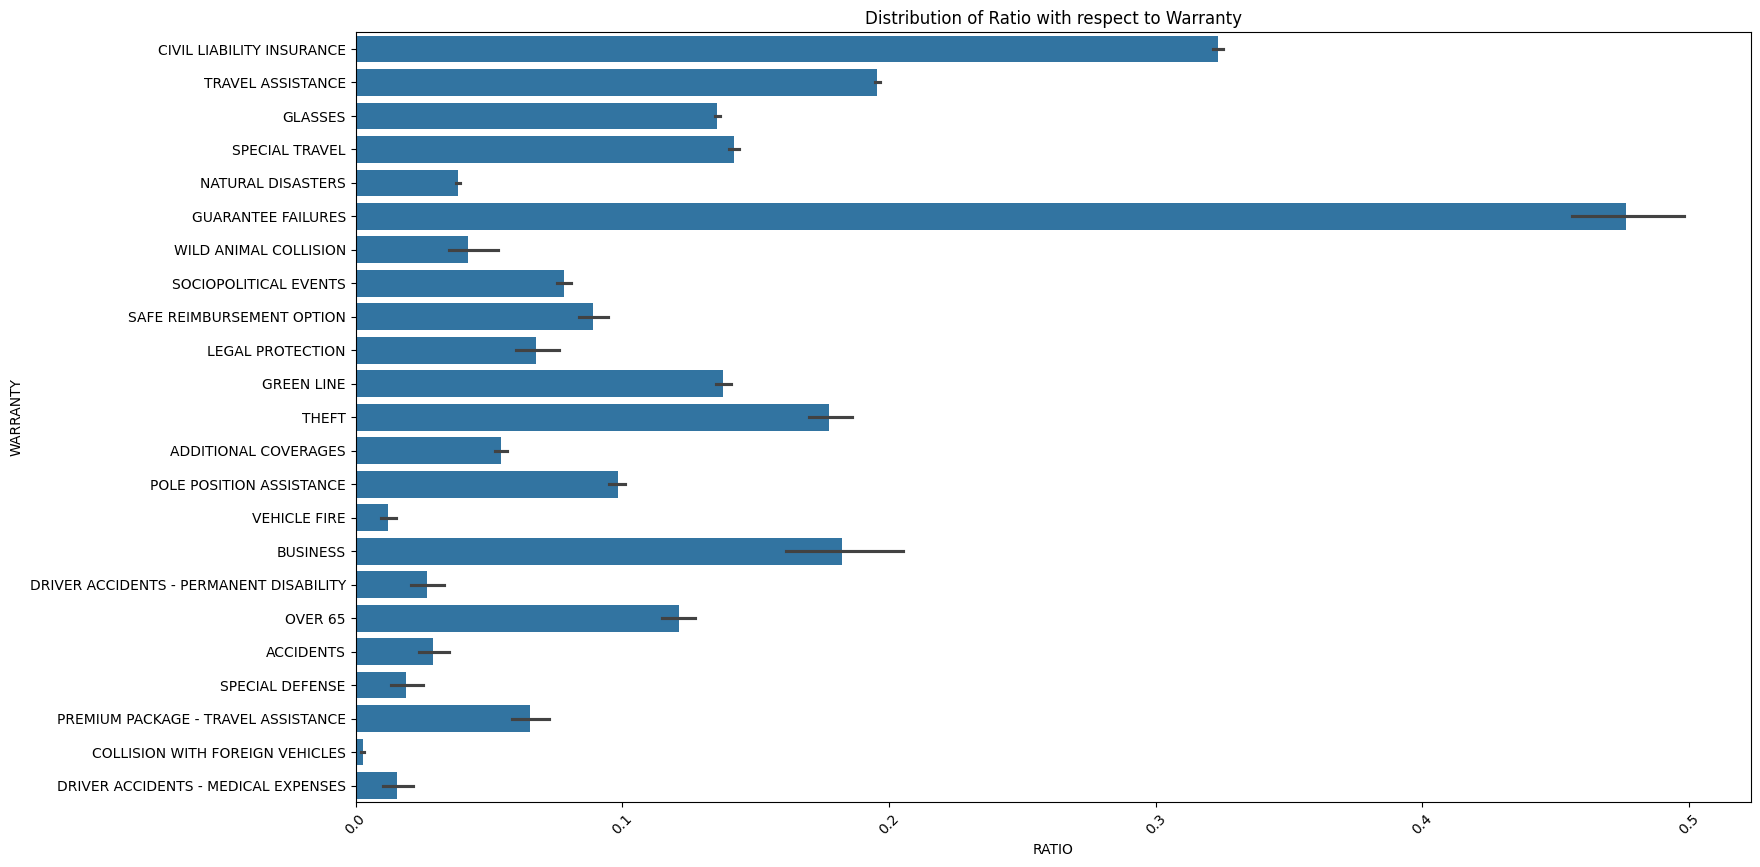

In [83]:
# Plot the distribution of the ratio with respect to WARRANTY
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.barplot(x='RATIO', y='WARRANTY', data=df)
plt.title('Distribution of Ratio with respect to Warranty')
plt.xticks(rotation=45)
plt.show()